In [94]:
import pandas as pd 
import datetime
from pandas_datareader import data as pdr 
import talib 
%matplotlib inline   
# esto hace que los gráficos se visualicen en el notebook
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab 
import statsmodels.api as sm 
import numpy as np

In [95]:
#Descargamos excel con datos intradiarios donde vamos a hacer el backtest
df = pd.read_csv('backtest-data/15-min/extended_intraday_MSFT_15min_year1month2_adjusted.csv') 
df=df[::-1].reset_index(drop=True) 
df.set_index('time',drop=True, inplace=True) 

#Periodo de la media movil 
sma_period=10

#Enseñamos primeros datos 
df.head()

,open,high,low,close,volume
time,,,,,
2020-09-10 04:15:00,210.10,210.10,208.00,209.10,6786
2020-09-10 04:30:00,209.11,209.50,209.10,209.50,5221
2020-09-10 04:45:00,209.99,209.99,209.62,209.62,1253
2020-09-10 05:00:00,209.94,210.10,209.54,209.54,3097
2020-09-10 05:15:00,209.50,210.30,209.50,210.30,4056


In [96]:
#Calculo de Half-Life
def apply_half_life(time_series):
    lag = np.roll(time_series, 1)
    lag[0] = 0
    ret = time_series - lag
    ret[0] = 0

    # adds intercept terms to X variable for regression
    lag2 = sm.add_constant(lag)

    model = sm.OLS(ret, lag2)
    res = model.fit()

    half_life = -np.log(2) / res.params[1] 

    return half_life 

In [97]:


#Dataframe de un mes antes para cálculo de niveles de entrada y salida 
df_hl= pd.read_csv('backtest-data/15-min/extended_intraday_MSFT_15min_year1month1_adjusted.csv') 
df_hl=df_hl[::-1].reset_index(drop=True) 
df_hl.set_index('time',drop=True, inplace=True) 
df_hl

,open,high,low,close,volume
time,,,,,
2020-10-12 04:15:00,216.21,216.40,216.21,216.40,1349
2020-10-12 04:30:00,216.66,217.50,216.66,217.50,2799
2020-10-12 04:45:00,217.53,217.86,217.50,217.50,4207
2020-10-12 05:00:00,217.45,217.45,217.39,217.39,586
2020-10-12 05:30:00,217.61,217.68,217.61,217.68,1260
...,...,...,...,...,...
2020-11-06 19:00:00,223.29,223.65,223.29,223.37,2074
2020-11-06 19:15:00,223.37,223.37,223.37,223.37,414
2020-11-06 19:30:00,223.41,223.46,223.26,223.26,3469


In [98]:


#Calculo de Half-Life
hl= int(apply_half_life(time_series=df_hl['close'])) 

print(hl) 

#Calculo de puntos de entrada y salida

# Añadimos media movil 
df_hl['SMA']= talib.SMA(df_hl['close'], timeperiod=sma_period) 

#Añadimos el spread entre el precio y la media 
df_hl['Spread']= df_hl['close'] - df_hl['SMA']

#Añadimos Z Score 
window=hl #En un periodo de half-life
col_mean = df_hl["Spread"].rolling(window=window).mean()
col_std = df_hl["Spread"].rolling(window=window).std()

df_hl["ZScore"] = (df_hl["Spread"] - col_mean)/col_std  

df_hl=df_hl.dropna(axis=0)  

#Usamos percentiles para el calculo de punto de entrada 

entry_short = df_hl[df_hl['ZScore']>0]['ZScore'].quantile(0.9) 
entry_long = df_hl[df_hl['ZScore']<0]['ZScore'].quantile(0.1) 
print(str(entry_long)) 
print(str(entry_short))


456
-1.9102917684338276
1.6350096223144377


In [99]:
#Añadimos el porcentaje de cambio diario
df['percent_change'] = df['close'].pct_change()

# Añadimos media movil 
df['SMA']= talib.SMA(df['close'], timeperiod=sma_period) 

#Añadimos el spread entre el precio y la media 
df['Spread']= df['close'] - df['SMA']

#Añadimos Z Score 
window=hl #En un periodo de half-life
col_mean = df["Spread"].rolling(window=window).mean()
col_std = df["Spread"].rolling(window=window).std()

df["ZScore"] = (df["Spread"] - col_mean)/col_std 

#Mostramos la nueva tabla
df=df.dropna(axis=0) 
df.head()

,open,high,low,close,volume,percent_change,SMA,Spread,ZScore
time,,,,,,,,,
2020-09-21 09:30:00,196.8108,197.30,196.510,196.8500,68661,-0.000863,196.56435,0.28565,0.419885
2020-09-21 09:45:00,197.1900,198.40,196.500,197.3357,3337503,0.002467,196.62292,0.71278,0.844065
2020-09-21 10:00:00,197.3400,198.75,197.055,197.9900,2109419,0.003316,196.87192,1.11808,1.242466
2020-09-21 10:15:00,197.9800,198.20,196.510,197.8000,1689854,-0.000960,197.03292,0.76708,0.890887
2020-09-21 10:30:00,197.7850,198.17,196.925,197.1800,1667094,-0.003134,197.03192,0.14808,0.276420


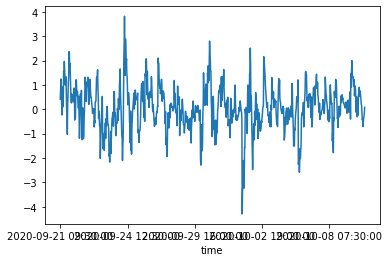

In [100]:
#Ploteamos el Z-Score
plt.figure() 
df.ZScore.plot() 
plt.show() 


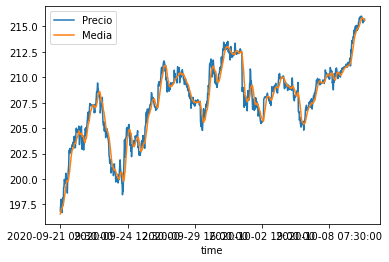

In [101]:
#Ploteamos la grafica de la empresa con la media 
plt.figure()
df.close.plot(label='Precio')
df.SMA.plot(label='Media')
plt.legend()
plt.show()

In [102]:
df

,open,high,low,close,volume,percent_change,SMA,Spread,ZScore
time,,,,,,,,,
2020-09-21 09:30:00,196.8108,197.3000,196.510,196.8500,68661,-0.000863,196.56435,0.28565,0.419885
2020-09-21 09:45:00,197.1900,198.4000,196.500,197.3357,3337503,0.002467,196.62292,0.71278,0.844065
2020-09-21 10:00:00,197.3400,198.7500,197.055,197.9900,2109419,0.003316,196.87192,1.11808,1.242466
2020-09-21 10:15:00,197.9800,198.2000,196.510,197.8000,1689854,-0.000960,197.03292,0.76708,0.890887
2020-09-21 10:30:00,197.7850,198.1700,196.925,197.1800,1667094,-0.003134,197.03192,0.14808,0.276420
...,...,...,...,...,...,...,...,...,...
2020-10-09 19:00:00,215.4300,215.4500,215.330,215.4500,1038,0.000464,215.76899,-0.31899,-0.530313
2020-10-09 19:15:00,215.5000,215.6000,215.500,215.5100,3077,0.000278,215.72200,-0.21200,-0.375251
2020-10-09 19:30:00,215.5600,215.5600,215.500,215.5100,2566,0.000000,215.67600,-0.16600,-0.305892


In [103]:
def señales(time_series):
    if time_series > entry_short: 
        return -1 
    elif time_series < entry_long: 
        return 1 
    else: 
        return 0        

df['Señal']=df['ZScore'].apply(lambda x: señales(x)) 
df['Strategy']= 0

In [104]:
for i in range(1,df.shape[0]-1): 
    
    #Abrir posicion de compra o venta
    if df['Strategy'].iloc[i-1]==0 and df['Señal'].iloc[i-1] != 0:
        df['Strategy'].iloc[i]=df['Señal'].iloc[i-1]
    
    #Cerrar posicion de compra
    elif df['ZScore'].iloc[i-1]>0.5 and df['Strategy'].iloc[i-1]==1: 
        df['Strategy'].iloc[i]=0 
    #Cerrar posición de venta 
    elif df['ZScore'].iloc[i-1]<-0.5 and df['Strategy'].iloc[i-1]==-1: 
        df['Strategy'].iloc[i]=0 
    else: 
        df['Strategy'].iloc[i]= df['Strategy'].iloc[i-1]
        
    
    


In [105]:
df.head(30)

,open,high,low,close,volume,percent_change,SMA,Spread,ZScore,Señal,Strategy
time,,,,,,,,,,,
2020-09-21 09:30:00,196.8108,197.300,196.5100,196.8500,68661,-0.000863,196.56435,0.28565,0.419885,0,0
2020-09-21 09:45:00,197.1900,198.400,196.5000,197.3357,3337503,0.002467,196.62292,0.71278,0.844065,0,0
2020-09-21 10:00:00,197.3400,198.750,197.0550,197.9900,2109419,0.003316,196.87192,1.11808,1.242466,0,0
2020-09-21 10:15:00,197.9800,198.200,196.5100,197.8000,1689854,-0.000960,197.03292,0.76708,0.890887,0,0
2020-09-21 10:30:00,197.7850,198.170,196.9250,197.1800,1667094,-0.003134,197.03192,0.14808,0.276420,0,0
2020-09-21 10:45:00,197.1500,197.390,196.3800,196.7000,1323639,-0.002434,197.06992,-0.36992,-0.236280,0,0
2020-09-21 11:00:00,196.6900,197.980,196.5300,197.7272,1629187,0.005222,197.16464,0.56256,0.686234,0,0
2020-09-21 11:15:00,197.7200,198.840,197.5500,198.1300,1374238,0.002037,197.33529,0.79471,0.914772,0,0
2020-09-21 11:30:00,198.1358,198.180,196.9100,197.3750,1023439,-0.003811,197.41079,-0.03579,0.094008,0,0


In [106]:
#Calculamos los retornos de la estrategia
df['strategy_returns'] = df.percent_change * df.Strategy 

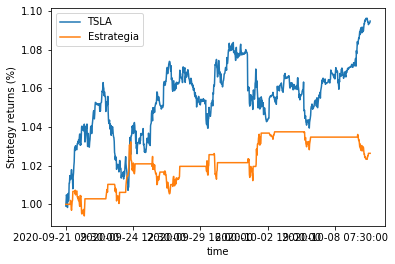

In [107]:
plt.figure()

(df.percent_change+1).cumprod().plot(label='TSLA')
(df.strategy_returns+1).cumprod().plot(label='Estrategia')
plt.ylabel('Strategy returns (%)')
plt.legend()
plt.show()

In [108]:
#Calculamos el numero de trades realizados, agrupando las estrategias en mismos grupos 
df_comisiones=df.copy()
numero_operaciones=0
for k,v in df_comisiones.groupby((df_comisiones['Strategy'].shift() != df_comisiones['Strategy']).cumsum()): 
    print(f'grupo {k}')
    print('\n') 
    if v['Strategy'].iloc[0]!=0: 
        numero_operaciones= numero_operaciones +1



grupo 1


grupo 2


grupo 3


grupo 4


grupo 5


grupo 6


grupo 7


grupo 8


grupo 9


grupo 10


grupo 11


grupo 12


grupo 13


grupo 14


grupo 15


grupo 16


grupo 17


grupo 18


grupo 19


grupo 20


grupo 21


grupo 22


grupo 23


grupo 24


grupo 25


grupo 26


grupo 27


grupo 28


grupo 29


grupo 30


grupo 31


grupo 32


grupo 33


grupo 34


grupo 35


grupo 36


grupo 37




In [109]:
print(f'El numero de operaciones realizadas en este mes son {numero_operaciones} con un coste total de {numero_operaciones*1.1}€') 


El numero de operaciones realizadas en este mes son 18 con un coste total de 19.8€


In [110]:
#Calculamos la duracion media de una operacion
tradecount=0
for k,v in df_comisiones.groupby((df_comisiones['Strategy'].shift() != df_comisiones['Strategy']).cumsum()): 
    print(f'grupo {k}')
    print('\n') 
    if v['Strategy'].iloc[0]!=0: 
        tradecount= tradecount + len(v.index) 
        

grupo 1


grupo 2


grupo 3


grupo 4


grupo 5


grupo 6


grupo 7


grupo 8


grupo 9


grupo 10


grupo 11


grupo 12


grupo 13


grupo 14


grupo 15


grupo 16


grupo 17


grupo 18


grupo 19


grupo 20


grupo 21


grupo 22


grupo 23


grupo 24


grupo 25


grupo 26


grupo 27


grupo 28


grupo 29


grupo 30


grupo 31


grupo 32


grupo 33


grupo 34


grupo 35


grupo 36


grupo 37




In [111]:
print(f'La duración media de los trades es igual a {tradecount/numero_operaciones} minutos')

La duración media de los trades es igual a 15.11111111111111 minutos
